In [3]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
test_scores = pd.read_csv(pm.get_data("test_scores.csv"), index_col=0)
test_scores.head()

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


,score,male,siblings,family_inv,non_english,prev_disab,age_test,non_severe_hl,mother_hs,early_ident,non_white
0,40,0,2.0,2.0,False,NaN,55,1.0,NaN,False,False
1,31,1,0.0,NaN,False,0.0,53,0.0,0.0,False,False
2,83,1,1.0,1.0,True,0.0,52,1.0,NaN,False,True
3,75,0,3.0,NaN,False,0.0,55,0.0,1.0,False,False
5,62,0,0.0,4.0,False,1.0,50,0.0,NaN,False,False


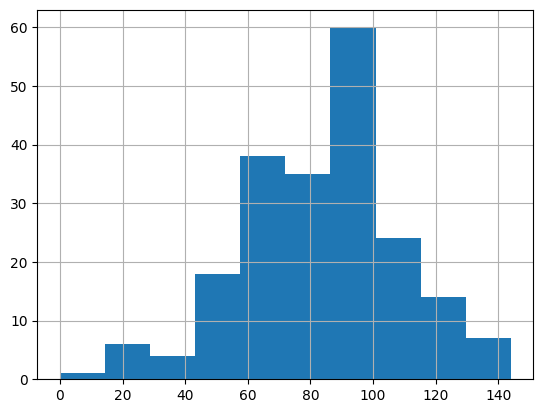

In [4]:
test_scores["score"].hist();

In [5]:
# Dropping missing values is a very bad idea in general, but we do so here for simplicity
X = test_scores.dropna().astype(float)
y = X.pop("score")

# Standardize the features
X -= X.mean()
X /= X.std()

N, D = X.shape

D0 = int(D / 2)

In [7]:
import pytensor.tensor as at

with pm.Model(coords={"predictors": X.columns.values}) as test_score_model:
    # Prior on error SD
    sigma = pm.HalfNormal("sigma", 25)

    # Global shrinkage prior
    tau = pm.HalfStudentT("tau", 2, D0 / (D - D0) * sigma / np.sqrt(N))
    # Local shrinkage prior
    lam = pm.HalfStudentT("lam", 5, dims="predictors")
    c2 = pm.InverseGamma("c2", 1, 1)
    z = pm.Normal("z", 0.0, 1.0, dims="predictors")
    # Shrunken coefficients
    beta = pm.Deterministic(
        "beta", z * tau * lam * at.sqrt(c2 / (c2 + tau**2 * lam**2)), dims="predictors"
    )
    # No shrinkage on intercept
    beta0 = pm.Normal("beta0", 100, 25.0)

    scores = pm.Normal("scores", beta0 + at.dot(X.values, beta), sigma, observed=y.values)

In [9]:
with test_score_model:
    prior_samples = pm.sample_prior_predictive(100)

Sampling: [beta0, c2, lam, scores, sigma, tau, z]


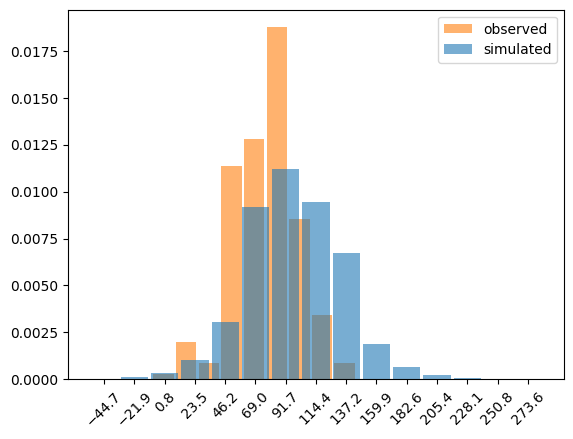

In [10]:
az.plot_dist(
    test_scores["score"].values,
    kind="hist",
    color="C1",
    hist_kwargs=dict(alpha=0.6),
    label="observed",
)
az.plot_dist(
    prior_samples.prior_predictive["scores"],
    kind="hist",
    hist_kwargs=dict(alpha=0.6),
    label="simulated",
)
plt.xticks(rotation=45);

In [11]:
with test_score_model:
    idata = pm.sample(1000, tune=2000, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, tau, lam, c2, z, beta0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 10 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


In [12]:
with test_score_model:
    idata = pm.sample(1000, tune=2000, random_seed=42, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, tau, lam, c2, z, beta0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 27 seconds.


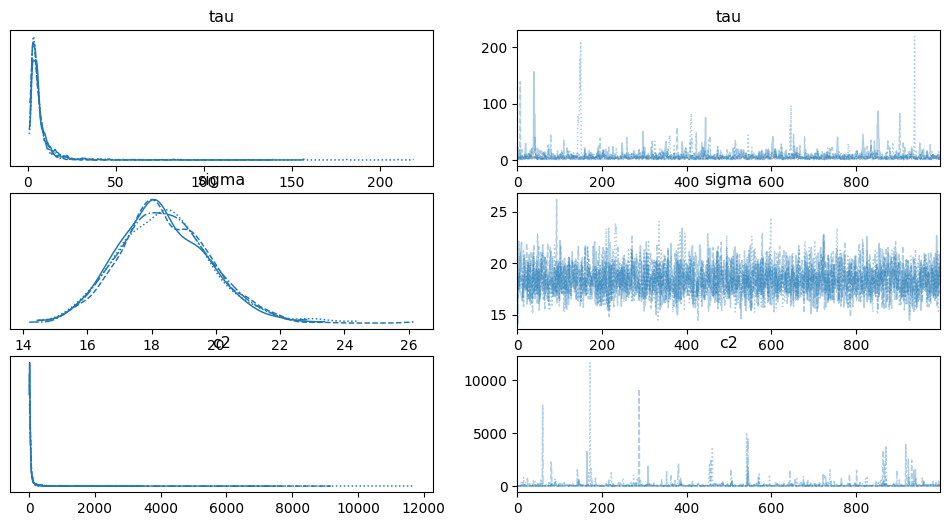

In [13]:
az.plot_trace(idata, var_names=["tau", "sigma", "c2"]);

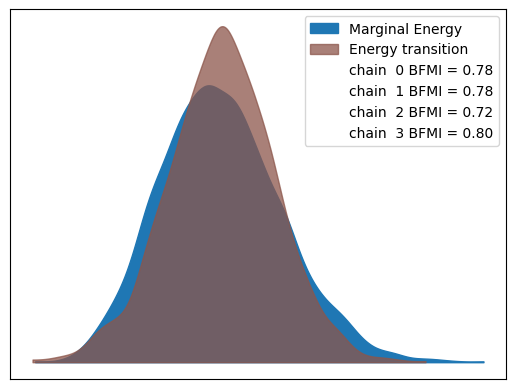

In [14]:
az.plot_energy(idata);

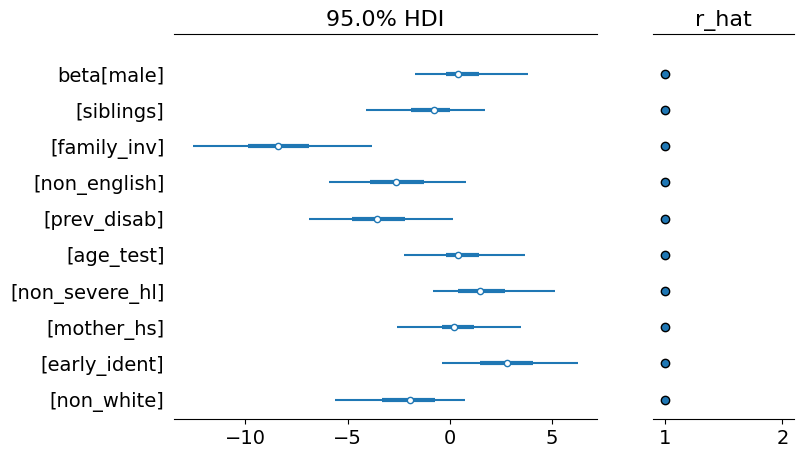

In [15]:
az.plot_forest(idata, var_names=["beta"], combined=True, hdi_prob=0.95, r_hat=True);